In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [9]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')
test_train = pd.concat([train_df, test_df])
test_train.set_index('PassengerId', inplace=True)
test_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
test_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


Признак **Cabin** можем сходу удалить, так как в нем больше 45% пропусков. В остальных колонка пропусков не так много, поэтому можно продолжать с ними работать

In [12]:
test_train.drop(['Cabin', 'Name'], inplace=True, axis=1)

In [13]:
all_columns = list(test_train.columns)
cat_columns = [col for col in all_columns if test_train[col].dtype == 'object']
int_float_columns = [col for col in all_columns if test_train[col].dtype == 'int' or test_train[col].dtype == 'float']
small_cat_columns = [col for col in cat_columns if test_train[col].nunique() < 4]
big_cat_columns = [col for col in cat_columns if test_train[col].nunique() > 3]
big_cat_columns

['Ticket']

In [14]:
len(big_cat_columns) + len(small_cat_columns) + len(int_float_columns) == test_train.shape[1]

True

Складываем размерности наших колонок и размерность таблиц. Вывело True - значит все верно

In [16]:
def part_of_distr(df, col):
    new_df = df.groupby(col).agg({col: 'count'})
    new_df['Part'] = new_df[col] / len(df)
    print(new_df)
    print()
    sns.countplot(x=df[col], data=df, palette='viridis', hue=col, legend=False)
    plt.show()

        Sex      Part
Sex                  
female  466  0.355997
male    843  0.644003



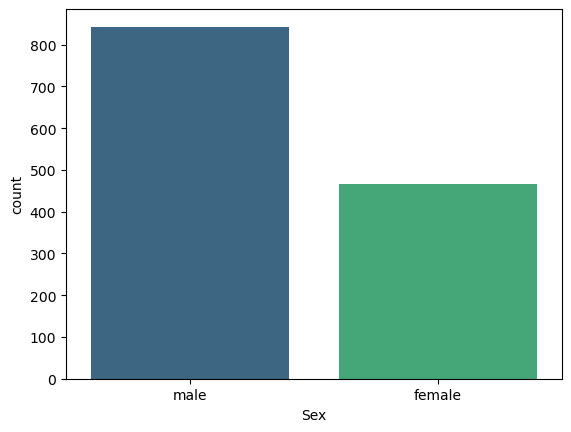

             Ticket      Part
Ticket                       
110152            3  0.002292
110413            3  0.002292
110465            2  0.001528
110469            1  0.000764
110489            1  0.000764
...             ...       ...
W./C. 6608        5  0.003820
W./C. 6609        1  0.000764
W.E.P. 5734       2  0.001528
W/C 14208         1  0.000764
WE/P 5735         2  0.001528

[929 rows x 2 columns]



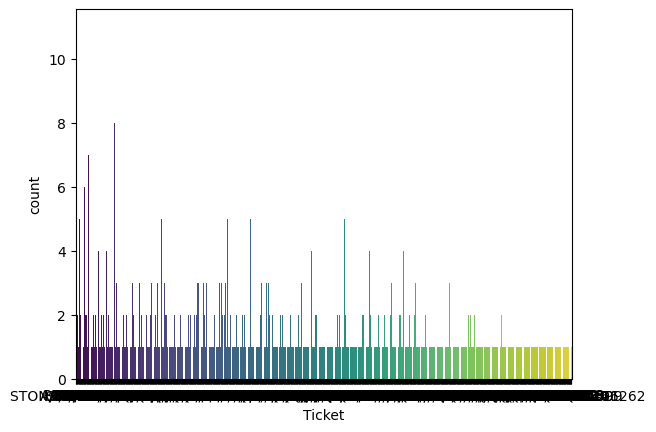

          Embarked      Part
Embarked                    
C              270  0.206264
Q              123  0.093965
S              914  0.698243



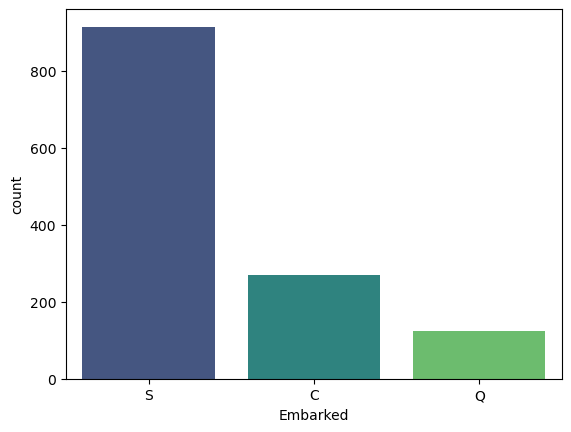

In [17]:
for col in cat_columns:
    part_of_distr(test_train, col)

В целом, если будем смотреть на **распределение данных**, то у нас нет **аномальных данных**, но в стобце **Ticket** слишком много уникальных значений, поэтому в дальнейшем удалим этот призйнак, иначе рискуем **получить переобучение**

Теперь посчитаем корреляцию по вещественным переменным

In [19]:
(test_train[int_float_columns].corr())['Survived'].sort_values()

Pclass     -0.338481
Age        -0.077221
SibSp      -0.035322
Parch       0.081629
Fare        0.257307
Survived    1.000000
Name: Survived, dtype: float64

Даже для **решающего дерева** мы тоже должны считать **корреляцию**. Уберем колонки где корреляция по модуля ниже или равно **0.05**

Это только **один** признак - `SibSp`

In [21]:
test_train.drop('SibSp', axis=1, inplace=True)

In [22]:
del int_float_columns[int_float_columns.index('SibSp')]

Теперь посчитаем процент пропусков в категориальных колонках. где будет больше 45% - будем удалять

In [24]:
(test_train[cat_columns].isnull().sum()) / len(test_train)

Sex         0.000000
Ticket      0.000000
Embarked    0.001528
dtype: float64

Мы видим, что у нас нет колонки, где было бы больше **45% пропусков** (изначально была **одна** такая - но мы ее уже удалили). 

Ну и заполним пропуски в признаке `Embarked` **модой** - самым популярным значением

In [26]:
test_train['Embarked'] = test_train['Embarked'].fillna(test_train['Embarked'].value_counts().index[0])
(test_train[cat_columns].isnull().sum()) / len(test_train)

Sex         0.0
Ticket      0.0
Embarked    0.0
dtype: float64

Теперь у нас **нет** пропусков в **категориальных колонках**

Проверим **пропуски** в вещественных колонках. И заполним **средним** значением по нашей выборке

In [28]:
(test_train[int_float_columns].isnull().sum()) / len(test_train)

Survived    0.319328
Pclass      0.000000
Age         0.200917
Parch       0.000000
Fare        0.000764
dtype: float64

In [29]:
for col in int_float_columns:
    if (test_train[col].isnull().sum()) / len(test_train) != 0 and col != 'Survived':
        test_train[col] = test_train[col].fillna(test_train[col].mean())
(test_train[int_float_columns].isnull().sum()) / len(test_train)

Survived    0.319328
Pclass      0.000000
Age         0.000000
Parch       0.000000
Fare        0.000000
dtype: float64

Отлично, теперь у нас нет пропусков и в вещественных колонках (кроме признака `Survived`, но там и должны быть, ведь это тестовые данные)

Теперь перейдем к кодировке. Перед эти уберем еще колонку с билетами, так как в ней слишком много уникальных значений.

Будес использовать one-hot-encoding для колонок, где уникальных значений меньше 3х и Mean target encoding в остальных случая

In [31]:
test_train_copy = test_train.copy()
test_train.drop('Ticket', axis=1, inplace=True)
del cat_columns[cat_columns.index('Ticket')]
for col in cat_columns:
    if test_train[col].nunique() < 4:
        one_hot_encoding = pd.get_dummies(test_train_copy[col], prefix=col, drop_first=True, dtype="int")
        test_train_copy = pd.concat([test_train_copy, one_hot_encoding], axis=1)
        test_train_copy.drop(col, axis=1, inplace=True)
    else:
        mean_target_encoding = test_train_copy.groupby(col)['Survived'].mean()
        test_train_copy[col] = test_train_copy[col].map(mean_target_encoding)

In [32]:
test_train_copy.drop('Ticket', axis=1, inplace=True)
test_train_copy.head()

,Survived,Pclass,Age,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,
1,0.0,3,22.0,0,7.2500,1,0,1
2,1.0,1,38.0,0,71.2833,0,0,0
3,1.0,3,26.0,0,7.9250,0,0,1
4,1.0,1,35.0,0,53.1000,0,0,1
5,0.0,3,35.0,0,8.0500,1,0,1


In [33]:
test_df = test_train_copy[test_train_copy['Survived'].isnull()]
train_df = test_train_copy[~test_train_copy['Survived'].isnull()]
test_df.head()

,Survived,Pclass,Age,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,
892,NaN,3,34.5,0,7.8292,1,1,0
893,NaN,3,47.0,0,7.0000,0,0,1
894,NaN,2,62.0,0,9.6875,1,1,0
895,NaN,3,27.0,0,8.6625,1,0,1
896,NaN,3,22.0,1,12.2875,0,0,1


In [34]:
train_df.head()

,Survived,Pclass,Age,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,
1,0.0,3,22.0,0,7.2500,1,0,1
2,1.0,1,38.0,0,71.2833,0,0,0
3,1.0,3,26.0,0,7.9250,0,0,1
4,1.0,1,35.0,0,53.1000,0,0,1
5,0.0,3,35.0,0,8.0500,1,0,1


In [35]:
train_df.to_csv('train_transform.csv')
test_df.to_csv('test_transform.csv')

Можно посчитать средний возраст у выживших и не выживших, посчитать стд, гистограммы для куч, либо боксплоты

Делаем список списков, есть оптимальный j, trashhold, ссылка на левую и правую вершины

In [38]:
train_df.shape

(891, 8)